# Risk and Bias-Variance Trade-Off
We consider a univariate regression problem where we want to predict the variable $y$ knowing one variable $x$.


## 1 A (Very) Small Introduction to Jupyter Notebook
Jupyter notebook are `.ipynb` files documents containing cells. There are two kinds of cells: 
1. Markdown cells that contain text;
2. Code cells that contain executable code.

All the code cells can be edited. The different code cells share the same namespace. In order to execute one code cell, you can use two keyboard shortcuts:

- `Ctrl`+`Return`: it will execute the current cell;
- `Shift`+`Return`: it will execute the current cell, and then the current cell will be the cell below.


<font color='red'>**Q1:**</font> Execute the code cell below.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

# read .csv file and return a pandas DataFrame object
s = pd.read_csv("lab1.csv")
s.describe()

,x,y
count,80.000000,80.000000
mean,8.026546,-2.806917
std,4.476957,14.590826
min,0.265853,-26.864340
25%,4.354277,-13.542744
50%,8.009389,-4.566818
75%,11.858389,5.924407
max,14.963306,32.376107


<font color='red'>**Q2:**</font> All the code cells can be edited. Edit the one below to plot $y$ as a function of $x$.

<font color='green'>**Hints for Q2:**</font> To do this, you can use the function `scatter` of the module `plt` of the `matplotlib` library. The variable `x` of a pandas DataFrame `s` can be accessed with `s.x` or equivalently `s["x"]`.

Text(0.5, 1.0, 'Scatter y=f(x) where f is unknown')

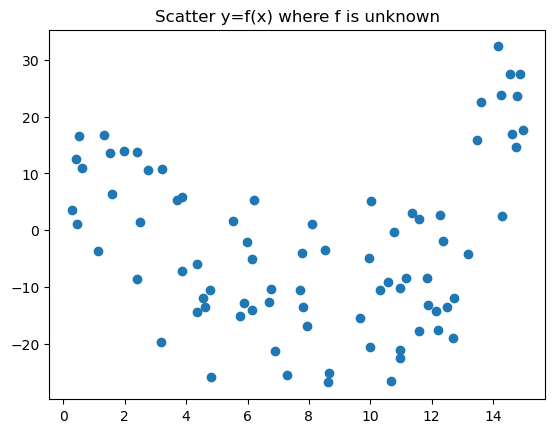

In [3]:
fig = plt.figure()
plt.scatter(s.x, s.y)
plt.title("Scatter y=f(x) where f is unknown")

## 2 Ridge Regression
In this section, we want to fit a polynomial model to the data. This can be done using a linear model $y=\beta_0+\sideset{}{_{i=1}^d}\sum  \beta_i x^i$. The coefficients ${(\beta_i)}_{0 \leq i\leq d}$ of such a model can be obtained by a ridge regression.

The function `fitridge(s,alpha)` returns a $10^{th}$ degree polynomial model fitted using a Ridge procedure on the data set `s` and the regularizing parameter `alpha`.

In [4]:
def fitridge(s, alpha):
    poly =  sklearn.preprocessing.PolynomialFeatures(10, include_bias=False)
    scale = sklearn.preprocessing.StandardScaler()
    ridge = sklearn.linear_model.Ridge(alpha=alpha)
    model = sklearn.pipeline.make_pipeline(poly, scale, ridge)
    model.fit(s[["x"]], s.y)
    # please note that s[["x"]] returns a pandas dataFrame (so a 2D matrix) containing the columns ["x"]
    # whereas s["x"] returns a pandas Series (a 1D vector)
    return model

<font color='red'>**Q3:**</font> Using `fitridge`, fit a 10 degree polynomial models to `s` using differents values `alpha`. Then, using `plotmodel` with the additionnal argument `color="red"` or `color="blue"` for instance, plot different polynomial models (_i.e._ different alpha) with different colors.

<font color='green'>**Hints for Q3:**</font> Please note that, if `h` is the value returned by `fitridge`, then `plotmodel(h.predict,plotrange)` will plot the curve associated with the fitted model `h`.

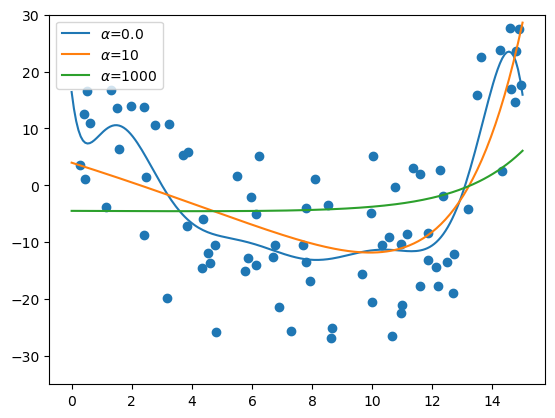

In [22]:
def plotmodel(modelpredict, plotrange, **kwargs):
    x = np.linspace(plotrange[0], plotrange[1], 200)
    dfx = pd.DataFrame({"x":x})
    y = modelpredict(dfx)
    y = y if len(y.shape) == 1 else [yi for yi in y.x]
    plt.plot(x,y, **kwargs)
    plt.ylim((-35,30))

plotrange = (0, 15)
ALPHA = [0., 10, 1000]
for alpha in ALPHA:
    h = fitridge(s, alpha)
    plotmodel(h.predict, plotrange, label=fr"$\alpha$={alpha}")
plt.scatter(s.x, s.y)
plt.legend()


<font color='red'>**Q4:**</font> Using these plots, find 3 values of alpha $\alpha_{under}$, $\alpha_{well}$ and $\alpha_{over}$ to obtain 3 models that respectively under-fit, fit well and over-fit. To help you decide, re-run the cell with several different values.

$\alpha_{over}=0$ correspond à une sur-estimation (sur apprentisage car le modèle tend à apprendre sur les observations).

$\alpha_{well}=10$ correspond à une bonne modélisation du modèle car la courbe suit les observations en moyenne.

$\alpha_{under}=1000$ correspond à une sous-estimation (le modèle ne colle pas du tout aux observations).



# 3 Risk and Empirical Risk



In general, the visual method used in the previous question cannot be used to choose alpha because several explanatory variables are involved. Furthermore, we might want to quantify and automate this process.


The goal in the regression problem is to minimize the expected loss when $h$ is used to predict $y$ when $(x,y)$ are drawn from $(X,Y)$ _i.e._ minimize the **risk** $R$: $$R(h)=\mathbb{E}_{X,Y}\left[l\left(h(X),Y\right)\right]$$

Thus we just have to find an alpha minimizing the **risk**. However, the **risk** cannot be computed without knowing the jointly distributed random variables $(X,Y)$.


For want of anything better, using a set $s$ of $n$ draws from $(X,Y)$, one can compute the **empirical risk**:

$$R_{\text{emp}}(h,s)=\frac{1}{\text{number of examples in}~s} \underset{(x,y) \in s}{\sum} l\left(h(x),y\right)$$


Thus, a suitable method to select an alpha is to split the set $s$ in two parts, the first part is used as a _training set_ $\mathrm{ts}$ and the second part as a _validation set_ $\mathrm{vs}$. The _training set_ is used to fit the model $h_{\mathrm{ts}}$ and the _validation set_ is used to estimate the performance of the model. The model with the best performance will be the selected one.


Let us consider a quadratic loss $l(\hat{y},y)=(\hat{y}-y)^2$.


<font color='red'>**Q5:**</font> Write the function `risk_emp(h,s)` that returns $R_{\text{emp}}(h,s)$. 

<font color='green'>**Hints for Q5:**</font> To do so, you can assume that `h` has a method `predict` that returns an array of the values predicted by `h` for the set `s`. The method `h.predict` takes a 2-D matrix as input. Thus, its input will be `s[["x"]]`, not `s.x`.




In [36]:
def risk_emp(h, s):
    y_hat = h(s[["x"]])
    err_square   = (y_hat - s.y)**2.
    return err_square.mean()

alpha = 10
h = fitridge(s , alpha)

risk_emp(h.predict, s)

97.65455357384367

<font color='red'>**Q6:**</font> Split `s` evenly into  a _training set_ $\mathrm{ts}$ and a _validation set_ $\mathrm{vs}$ with $40$ examples each. Fit the model with $\mathrm{ts}$. What estimates $\mathrm{risk}_{emp}(h_{\mathrm{ts}},\mathrm{vs})$? How does it compare to $\mathrm{risk}_{emp}(h_{\mathrm{ts}},\mathrm{ts})$?

Pour l'erreur d'entrainement on a une erreur de 94.975 alors que pour l'erreur de test on est à 129.85. C'est normale car on entraine sur le train et on test la généralisation.


<font color='red'>**Q7:**</font> Using `risk_emp`, verify that $\alpha_{well}$ gives a better performance than $\alpha_{over}$ and $\alpha_{under}$.

Effectivement on remarque que le $\alpha_{well}=10$ donne un meilleur résultat que les deux autres. En effet, le alpha de sur-apprentissage a un bon résultat sur l'entrainement mais pas en généralisation (test). Pour le alpha de sous-apprentissage on est pas bon dans les deux cas (train et test)

In [46]:
from sklearn.model_selection import train_test_split
ts, vs = train_test_split(s, test_size=40, train_size=40)

for alpha in ALPHA:
    h = fitridge(ts , alpha)
    risk_emp_ts = risk_emp(h.predict, ts)
    risk_emp_vs = risk_emp(h.predict, vs)
    print("Training error for alpha = {} : {}".format(alpha, risk_emp_ts))
    print("Test error for alpha = {} : {}\n".format(alpha, risk_emp_vs))

Training error for alpha = 0.0 : 62.49101058593622
Test error for alpha = 0.0 : 112.67170893122761

Training error for alpha = 10 : 87.23477008022351
Test error for alpha = 10 : 124.84645263286332

Training error for alpha = 1000 : 161.20673147914673
Test error for alpha = 1000 : 218.1459537732254



# 4 Bias-Variance Trade-Off


In this section, we look at the bias-variance trade-off. For a given $X=x_0$, the expected loss using a given model $h_s$ is $\mathbb{E}_{Y|X=x_0}\left[\left(Y-h_s\left(x_0\right)\right)^2\right]$. It tells us how precise a fixed model $h_s$ is. If we want to know if a learning algorithm is "efficient" using sets of $n$ examples (not a specific set!), we have to look at $\mathbb{E}_{s,Y|X=x_0}\left[\left(Y-h_s\left(x_0\right)\right)^2\right]$. It gives the average expected loss obtained using a given learning algorithm on sets of $n$ examples coming from the considered $(X,Y)$ law.

To better understand this average expected loss, we can decompose this term in two terms called the **_bias_** and the **_variance_**:
$$\mathbb{E}_{s,Y|X=x_0}\left[\left(Y-h_s\left(x_0\right)\right)^2\right]=\underset{\text{average squared bias}}{\underbrace{\mathbb{E}_{Y|X=x_0}\left[\left(Y-\mathbb{E}_{s}\left[h_s\left(x_0\right)\right]\right)^2\right]}}+\underset{\text{variance}}{\underbrace{\mathbb{E}_{s}\left[\left(\mathbb{E}_{s}\left[h_s\left(x_0\right)\right]-h_s\left(x_0\right)\right)^2\right]}}$$


<font color='red'>**The cell code below have a function `generate(n)` that generates a new data set containing $n$ observations of the variables $(X,Y)$ . Please note that, in most problems, all the functions in the cell code below are not available. Only one set of $n$ observations of $(X,Y)$ is available. In our case, it would be the data set stored in the file "lab1.csv". Likewise the true model `truemodel(x)` and the function generating samples from Y knowing x `generatey(x)` are not available in general.**
    
**For pedagocial purposes, these functions are available on our problem, we will use these functions to get a better understanding of the Bias-Varinace Trade-off.**
</font>

In [48]:
def truemodel(x):
    p = [1, 2, -1.3, 0.1, -0.001]
    res = 0
    # Horner's method to compute efficiently values of a polynom: a0 + x (a1 +x ( a2 + x ...)))
    for pi in reversed(p):
        res = pi + x * res
    return res


# generatey(x) is a function drawing random values from the unknown distribution Y|X=x.
# It generates an examples set of Y for a given X=x.
# This kind of examples set is not available in practical application.
def generatey(x):
    e = 10
    return truemodel(x) + e * np.random.randn(*x.shape) # np.randn(shape) draws an array of shape [shape] from N(0,1)


# generate(n) is a function drawing random values from the unknown distribution (X,Y).
# It generates a set of n examples.
# This kind of examples set is what you have in practical application.
# You have one example set in practical application that you generally split in at least two sets (training and validation sets).
def generate(n):
  a = 0
  b = 15
  x = a + (b - a) * np.random.rand(n) # np.random.rand(d0, d1, ...) generates d0 * d1 * ... values drawn in U(0,1).
  y = generatey(x)
  return pd.DataFrame({"x":x, "y":y})


<font color='red'>**Q8:**</font> The function `generate` is used to generate $(X,Y)$ data points. By reading the code of `generatey` and `generate`, guess what are the underlying distributions of $X$ and $Y\mid X$?


X suit une loi uniforme $U(0, 15)$

Y | X suit une loi normale $N(0, 100)$


## 4.1 Visualization of the $h_s$'s Randomness Caused by the $s$'s Randomness

<font color='red'>**Q9:**</font> The code below plots the true model in black. Add 20 models trained with different training sets to this plot. To do this, at each iteration, draw one training set of 40 samples, train one model using `fitridge` and plot it. Try different values of `alpha`, typically the three values $\alpha_{under}$, $\alpha_{well}$, $\alpha_{over}$ you found on <font color='red'>**Q4**</font>. In your opinion, if you had to play a lottery and draw one model out of these 20 models, which $\alpha$ would give you a better chance to draw a good model ?



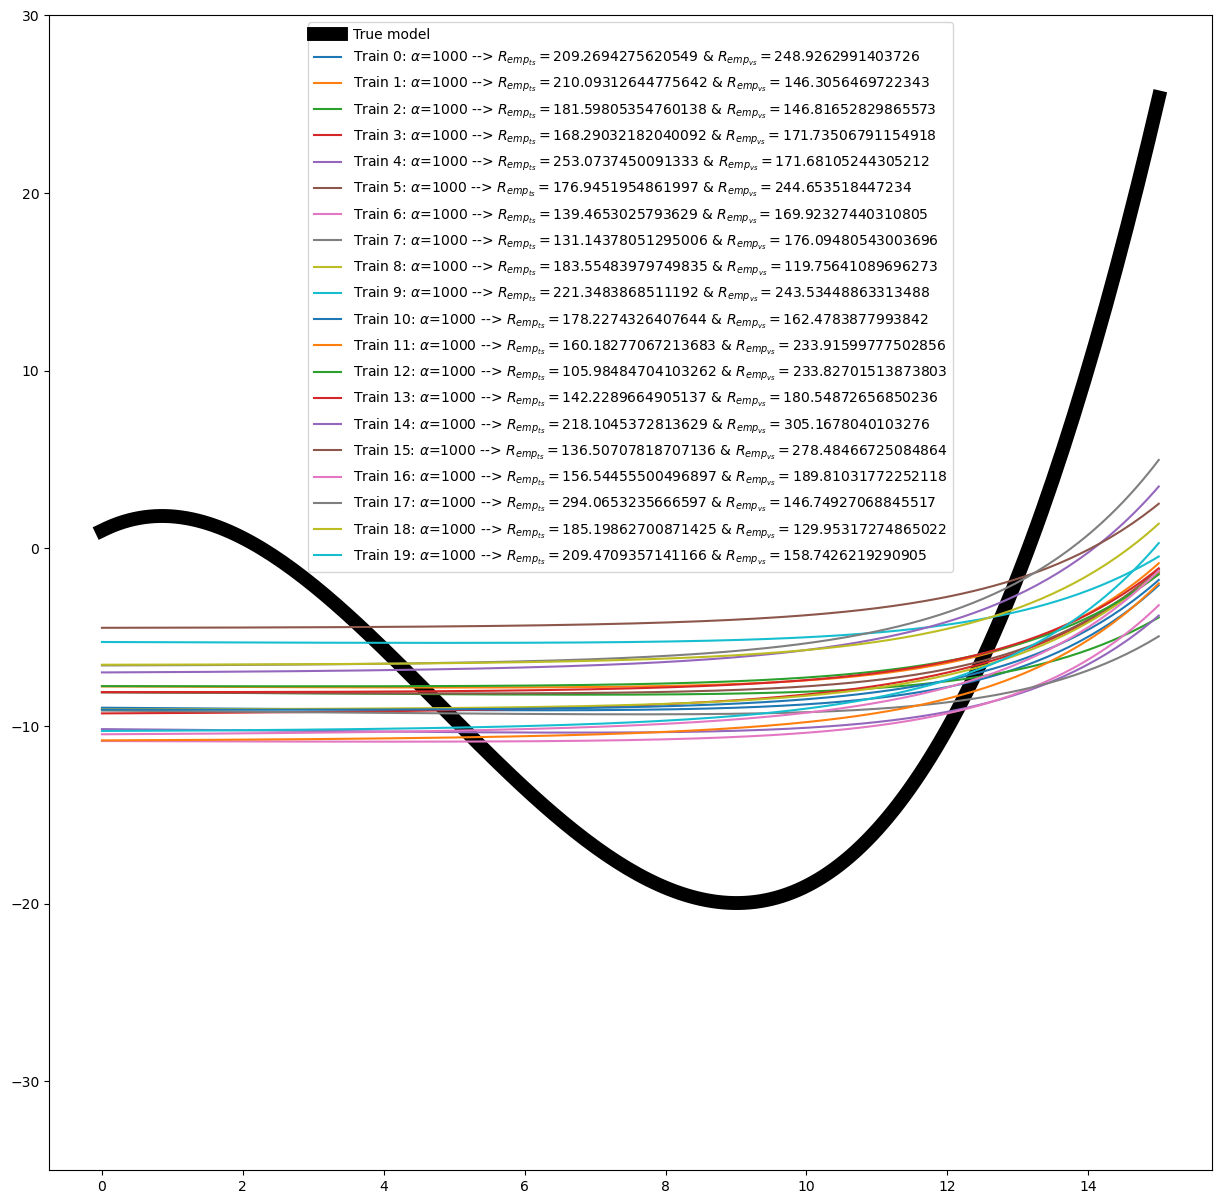

In [61]:
fig = plt.figure(figsize=(15, 15))
plotmodel(truemodel,plotrange,color="black",linewidth=10, label="True model")
for _ in range(20):
    # draw one training set, train a model on this trainig set, and then plot this model
    df = generate(80)
    ts, vs = train_test_split(df, test_size=40, train_size=40)
    for alpha in [10**3]: # 0 = overfit, 10**3 : under fit, 10 = well fit
        h = fitridge(ts, alpha)
        # Error
        risk_emp_ts = risk_emp(h.predict, ts)
        risk_emp_vs = risk_emp(h.predict, vs)
        
        label = fr"Train {_}: $\alpha$={alpha} --> $R_{{emp_{{ts}}}}={risk_emp_ts}$ & $R_{{emp_{{vs}}}}={risk_emp_vs}$"
        
        plotmodel(h.predict, plotrange, label=label)

plt.legend()
plt.show()

## 4.2 Computing the Variance in the Bias-Variance Decomposition

<font color='red'>**Q10:**</font> Write a function `compute_hx0s(x0,fit,k,n)` that returns an array of `k` values of $h_s(x_0)$. These `k` values are different from each other because, at each iteration, we compute a new $h_s$ using a new set $s$ of `n` examples. These $h_s$ are computed using the function call `fit(s)`.

<font color='green'>**Hints for Q10:**</font> As said before, if `hs` is a model, the input of `hs.predict` is a 2-D matrix. Thus, if we want to compute $h_s(x_0)$, we just have to call `hs.predict(np.array([[x0]]))` that will return vector of one element.



In [62]:
def compute_hx0s(x0, fit, k, n):
    res = np.zeros(k)
    for i in range(k):
        s = generate(n)
        h = fit(s)
        res[i] = h.predict(np.array([[x0]]))
    return res

<font color='red'>**Q11:**</font> For the following, we consider $x_0=7.5$ and $n=40$. Using `compute_hx0s` and `np.var`, compute an estimation of the **_variance_** term. The function `np.var` computes an unbiased estimate of the variance of a random variable from a vector of draws of this random variable. Once it is done, you can re-run the script several times in order to verify that the estimation of the variance doe not change much between two runs. If it is not the case you can increase `k` used for `compute_hx0s`.


Do this tuning procedure with the $\alpha=1e-10$ parameter for the ridge regression.

In [77]:
import warnings
warnings.filterwarnings("ignore")

X0s = compute_hx0s(x0=7.5, fit=lambda s: fitridge(s, 10**(-10)), k=1000, n=40)
X0s.var()

17.31328085513275

## 4.3 Computing the Bias in the Bias-Variance Decomposition
<font color='red'>**Q12:**</font> Using the array of $h_s(x_0)$'s computed  previously and `generatey`, compute an estimation of the **_bias_**. Once it is done, you can re-run the script several times in order to verify that the estimation of the bias does not change much between two runs. If it is not the case you can increase $k$ used for `compute_hx0s` and `generatey`.

<font color='green'>**Hints for Q12:**</font> We will use `np.repeat` to build the argument of `generatey`.



In [89]:
x0 = 7.5
X = np.repeat(x0, 1000)
Y = generatey(X)
Y_hat = compute_hx0s(x0=7.5, fit=lambda s: fitridge(s, 10**(-10)), k=1000, n=40)

stds = (Y - Y_hat.mean())**2
bias = stds.mean()

bias

108.60889409740197

## 4.4 Plotting the Bias and Variance as a Function of the Hyperparameter
<font color='red'>**Q13:**</font> Using a loop, compute three arrays: `alphas`, `biases` and `variances`. The `biases` and `variances` arrays contain the estimated biases and the estimated variances for different values of `alphas`.

Using a plot, illustrate the bias-variance trade-off seen in the lecture. To obtain a pretty plot, choose `np.log10(alphas)` as the x-axis.

What happens to these bias-variance curves if $n$ is divided by $2$?